In [1]:
!pip install wandb
!pip install torch
!pip install lightning
!pip install matplotlib
!pip install tqdm
!pip install sentence-transformers

^C
^C


# Inference of Text to Image Network

In [2]:
import torch
import lightning as L
from lightning.pytorch.loggers import WandbLogger
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

from datasets import EncodedMaskedMNIST, MaskedMNIST
from cINN import ConditionalRealNVPImageTranslator
from autoencoder import AutoencoderSimple
from classifier import CNN
from utils import get_best_device

## Load pretrained models

In [3]:
classifier_path = "./models/classifier_new_layer.pth"
classifier = CNN()
classifier.load_state_dict(torch.load(classifier_path, map_location=get_best_device()))

<All keys matched successfully>

In [4]:
ae_path = "./models/ae_100_new.pth"
autoencoder = AutoencoderSimple()
autoencoder.load_state_dict(torch.load(ae_path, map_location=get_best_device()))

<All keys matched successfully>

In [5]:
cinn = ConditionalRealNVPImageTranslator(input_size=64, hidden_size=128, n_blocks=20, condition_size=128)
cinn.load_state_dict(torch.load('cinn_inpainting.pth'))


<All keys matched successfully>

In [6]:
test_data = MaskedMNIST(train=False)
test_loader = DataLoader(test_data, batch_size=100, shuffle=True)

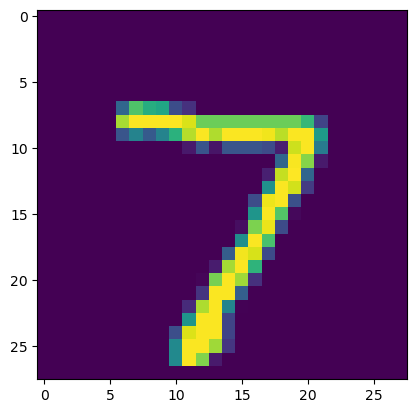

In [7]:
image, masked_image, label = test_data[0]
plt.imshow(image[0])

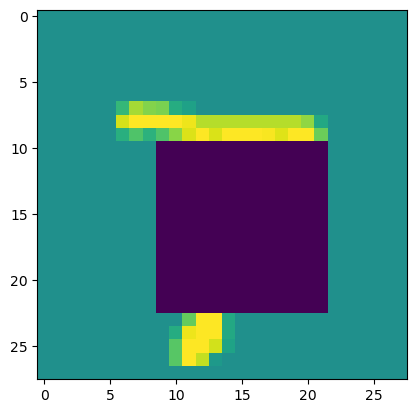

In [8]:
plt.imshow(masked_image[0])

## Sample with Condition

In [9]:
data = MaskedMNIST(train=False)

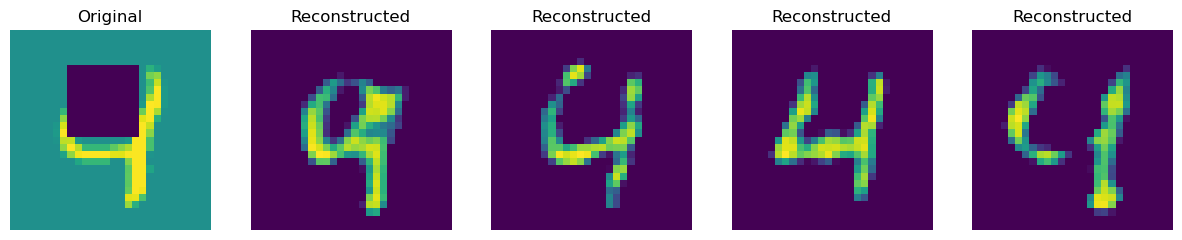

In [23]:
image, masked_image, label = data[4]
n_samples = 4

condition = classifier.encode(masked_image)
cinn.eval()
samples = cinn.sample(n_samples, condition)
reconstructed_images = [autoencoder.decoder(sample).detach() for sample in samples]

fig, ax = plt.subplots(1, n_samples+1, figsize=(15, 5)) # Create a figure and a set of subplots
# Display the original image
ax[0].imshow(masked_image[0,:,:])
ax[0].set_title('Original')  # Set title for the first image
ax[0].axis('off')  # Turn off axis for the first image

for i in range(0,n_samples):
# Display the reconstructed image
    ax[i+1].imshow(reconstructed_images[i][0,0,:,:])
    ax[i+1].set_title('Reconstructed')  # Set title for the second image
    ax[i+1].axis('off')  # Turn off axis for the second image


plt.show()

In [27]:
cinn.eval()
samples = cinn.sample(2, condition)

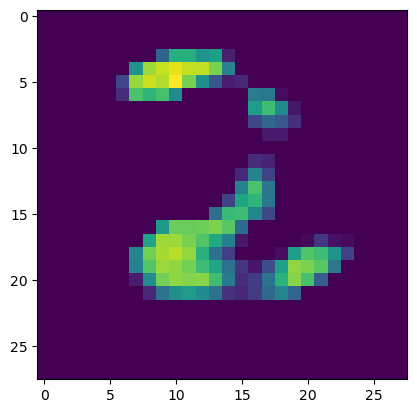

In [29]:
images = [autoencoder.decoder(sample).detach() for sample in samples]
plt.imshow(images[1][0,0,:,:])

In [15]:
import matplotlib.pyplot as plt
def display_image(tensor):
    """
    Display an image from a 4D PyTorch tensor.

    Parameters:
    - tensor: a PyTorch tensor of shape (1, 1, 28, 28)
    """
    if tensor.ndim == 4 and tensor.shape[1] == 1:
        # Remove the first two dimensions (batch size and channels) for display
        image = tensor.squeeze().detach()  # This should result in a 2D tensor for grayscale images
        plt.imshow(image, cmap='gray')
        plt.axis('off')  # Hide the axes
        plt.show()
    else:
        print("The input tensor does not have the correct shape.")

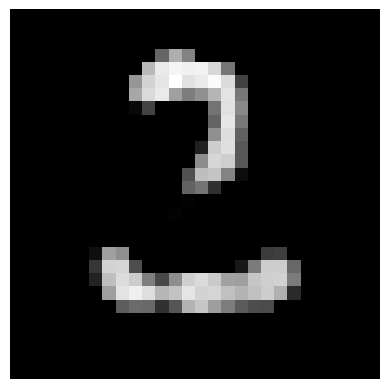

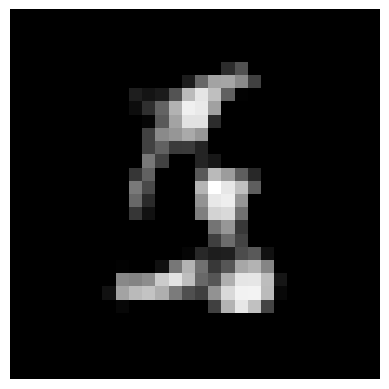

In [16]:
for image in images:
    display_image(image)